# postISR corner WFS: debug WCS with arrow stars

A notebook to show the diffence in using `WcsSol` vs `PhosimWcsSol`. 

The latter is not compatible with `skySim` WCS. 

I use arrows simulated on corner wavefront sensors using `skySim`, and show how the results of PhoSim simulation get passed to `ts_wep`


NB: We have to change the `bscDbType` manually before initializing `wep_calc`, because once `WEPCalculationFactory` is called, `updateSetting` won't do anything for `bscDbType` - because by then the sourceSelector had already been configured. The same with `expWcs`, since it's in the `__init` method of the `SourceSelector`. Other settings can be changed later , but before they are checked by the code . 

In [62]:
import os
import argparse
import numpy as np

from lsst.utils import getPackageDir
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.WepController import WepController
from lsst.ts.wep.Utility import CamType, FilterType, getModulePath, mapFilterRefToG, DefocalType
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use('dark_background')

import sys
sys.path.append('../analysis_tools/')
import analysisTools as at

#parts of analysis_tools/runCloseLoopPostISR.py
save_postage_stamps=True 
run_deblender=False
select_sensor = 'lsstcam' 
rerun='run1'
db_filename = 'bsc1.db3'
gaia_field_name=''
rotAngInDeg = 0
bscDbType='file'
setting_filename = 'default.yaml'
raInDeg=0
decInDeg=0


# updating bscDbType manually 
path_to_ts_wep = getPackageDir("ts_wep")
path_to_setting_file = os.path.join(path_to_ts_wep, 'policy',setting_filename)
settingFile = ParamReader(filePath=path_to_setting_file)
bscDbTypeInFile = settingFile.getSetting("bscDbType")
print('%s contains : '%path_to_setting_file, 
      bscDbTypeInFile)
if bscDbTypeInFile != bscDbType:
    # In the following we update the setting for bscDbType,
    # saving the change in the default.yaml file 
    settingFile.updateSetting("bscDbType", bscDbType)
    settingFile.saveSetting(filePath=path_to_setting_file)

    # check that the change indeed took place 
    settingFile = ParamReader(filePath=path_to_setting_file)
    print('After change: ', settingFile.getSetting("bscDbType"))

bscDataDir = os.path.join(path_to_ts_wep, 'tests/testData')
if db_filename  in os.listdir(bscDataDir):
    os.remove(os.path.join(bscDataDir,db_filename))
    print('Removed old %s file'%db_filename)
    



/astro/store/epyc/users/suberlak/Commissioning/aos/ts_wep/policy/default.yaml contains :  file
Removed old bsc1.db3 file


In [63]:
# update expWcs setting ... 
expWcs = True # using PhoSim WCS Sol 
settingFile= ParamReader(filePath=path_to_setting_file)
settingFile.updateSetting("expWcs", expWcs)
settingFile.saveSetting(filePath=path_to_setting_file)
settingFile = ParamReader(filePath=path_to_setting_file)
print('After change: expWcs : ', settingFile.getSetting("expWcs"))



########################
# Initialize wep_calc
########################
print('select_sensor is %s'%select_sensor)
if select_sensor == 'comcam':
    wep_calc = WEPCalculationFactory.getCalculator(CamType.ComCam, closed_loop_input_dir)
elif select_sensor  == 'lsstcam':
    wep_calc = WEPCalculationFactory.getCalculator(CamType.LsstCam, closed_loop_input_dir)
elif select_sensor == 'lsstfamcam':
    wep_calc = WEPCalculationFactory.getCalculator(CamType.LsstFamCam, closed_loop_input_dir)

    

After change: expWcs :  True
select_sensor is lsstcam


In [64]:
# this is only executed once 
# wep_calc._getTargetStar() is called 
#settingFile = wep_calc.getSettingFile()
dbRelativePath = 'tests/testData/%s'%db_filename
wep_calc.settingFile.updateSetting("defaultBscPath", dbRelativePath)

# if GAIA field name is not provided, we assume raInDeg, decInDeg as boresight 
print('\nSetting telescope boresight as (%.2f, %.2f)'%(raInDeg,decInDeg))
wep_calc.setBoresight(raInDeg, decInDeg)

print('\nSetting telescope rotation angle as %.2f'%rotAngInDeg)
wep_calc.setRotAng(rotAngInDeg)

# Set the output directory :   iter0/pert
outputDirName = "pert"
# set the sky file 
skyInfoFileName = 'skyLsstCamInfo.txt'
baseOutputDir = topDir
# the iteration directory 
iterCount = 0
iterDirName = "%s%d" % ("iter", iterCount)
outputDir = os.path.join(baseOutputDir, iterDirName, outputDirName)
outputSkyInfoFilePath = os.path.join(outputDir, skyInfoFileName)
print('Setting sky file as %s'%outputSkyInfoFilePath)
wep_calc.setSkyFile(outputSkyInfoFilePath)


# this is already part of 
# listOfWfErr = wepCalc.calculateWavefrontErrors(
#                 intraRawExpData, postageImg=postageImg, postageImgDir = postageImgDir,
#                 sensorNameToIdFileName=sensorNameToIdFileName)
postISRdir = os.path.join(closed_loop_input_dir, 'rerun/%s'%rerun)
print('Setting postISR CCD inputs as %s'%postISRdir)

wep_calc.wepCntlr.setPostIsrCcdInputs(postISRdir)
intraObsId = 9006002
extraObsId = 9006001
if select_sensor in ['lsstfamcam','comcam']:
    obsIdList = [intraObsId, extraObsId]
elif (select_sensor == 'lsstcam'):
    obsIdList = [intraObsId]
    



Setting telescope boresight as (0.00, 0.00)

Setting telescope rotation angle as 0.00
Setting sky file as /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/iter0/pert/skyLsstCamInfo.txt
Setting postISR CCD inputs as /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/input/rerun/run1


In [65]:
################################
# begin wep_calc._getTargetStar()

from lsst.ts.wep.Utility import getModulePath, getConfigDir, BscDbType, \
    FilterType, abbrevDetectorName, getBscDbType, getImageType, \
    getCentroidFindType, ImageType, DefocalType
    

# Now inside WEPCalculation.py, 
# Get the target stars map neighboring stars
#         neighborStarMap = self._getTargetStar(intraObsIdList,
#                                               DefocalType.Intra,
#                                               lowMagnitude, highMagnitude)


# inside _getTargetStar()
# we select the appropriate method to query the database 

sourSelc = wep_calc.wepCntlr.getSourSelc()
bscDbType = wep_calc._getBscDbType()

if bscDbType in (BscDbType.LocalDb, BscDbType.LocalDbForStarFile,
                         BscDbType.LocalDbFromImage, BscDbType.LocalDbFromRefCat):
    dbRelativePath = wep_calc.settingFile.getSetting("defaultBscPath")
    dbAdress = os.path.join(getModulePath(), dbRelativePath)
    sourSelc.connect(dbAdress)
sourSelc.setObsMetaData(wep_calc.raInDeg, wep_calc.decInDeg, 
                        wep_calc.rotSkyPos)
camDimOffset = wep_calc.settingFile.getSetting("camDimOffset")
skyFile = wep_calc._assignSkyFile()
print('The skyFile is %s'%skyFile)


The skyFile is /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars_2020_24_noPert/iter0/pert/skyLsstCamInfo.txt


In [66]:
from lsst.ts.wep.ctrlIntf.PhosimWcsSol import PhosimWcsSol
# Now get inside 
# neighborStarMap = sourSelc.getTargetStarByFile(skyFile, visitList, 
# offset=camDimOffset)[0]
# Get inside SourceSelector.py
# to dissect `sourSelc.getTargetStarByFile()`:
visitList = obsIdList
filterType = sourSelc.getFilter()
mappedFilterType = mapFilterRefToG(filterType)
if type(sourSelc.camera._wcs) == PhosimWcsSol:
    print('Using PhosimWcsSol')
    sourSelc.camera._wcs.setWcsDataFromIsrDir(mappedFilterType,
                                                sourSelc.camera.getWfsCcdList(),
                                            visitList[0])
else:
    print('Using ', sourSelc.camera._wcs)
    
skyFilePath = skyFile 
sourSelc.db.createTable(mappedFilterType)
sourSelc.db.insertDataByFile(skyFilePath, mappedFilterType, skiprows=1)

Using PhosimWcsSol
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22'}
{'visit': 9006002, 'filter': 'g', 'raftName': 'R04', 'detectorName': 'S20'}
{'visit': 9006002, 'filter': 'g', 'raftName': 'R40', 'detectorName': 'S02'}
{'visit': 9006002, 'filter': 'g', 'raftName': 'R44', 'detectorName': 'S00'}
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22'}
{'visit': 9006002, 'filter': 'g', 'raftName': 'R04', 'detectorName': 'S20'}
{'visit': 9006002, 'filter': 'g', 'raftName': 'R40', 'detectorName': 'S02'}
{'visit': 9006002, 'filter': 'g', 'raftName': 'R44', 'detectorName': 'S00'}


The next step would be to do 
    
    neighborStarMap, starMap, wavefrontSensors = self.getTargetStar(offset=offset)

where the following is done 

    wavefrontSensors = self.camera.getWavefrontSensor()
    lowMagnitude, highMagnitude = self.filter.getMagBoundary()

    # Query the star database
    starMap = dict()
    neighborStarMap = dict()
    for detector, wavefrontSensor in wavefrontSensors.items():

        # Get stars in this wavefront sensor for this observation field
        stars = self.db.query(mappedFilterType, wavefrontSensor[0],
                              wavefrontSensor[1], wavefrontSensor[2],
                              wavefrontSensor[3])

So I first check the location of each sensor as encoded in `camera.getWavefrontSensor()`

R:0,0 S:2,2,A
R:0,4 S:2,0,A
R:4,0 S:0,2,A
R:4,4 S:0,0,A
R:0,0 S:2,2,B
R:0,4 S:2,0,B
R:4,0 S:0,2,B
R:4,4 S:0,0,B


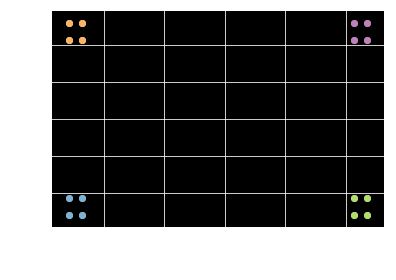

In [67]:
%matplotlib inline

fig,ax = plt.subplots(1,1,)
#thes coords are center of each sensor 
wavefrontSensors= sourSelc.camera.getWavefrontSensor()
for detector, wavefrontSensor in wavefrontSensors.items():
    print(detector)#, wavefrontSensor)  
 
    corner1 = wavefrontSensor[0]
    corner2 = wavefrontSensor[1]
    corner3 = wavefrontSensor[2]
    corner4 = wavefrontSensor[3]
    ra = np.array([corner1[0], corner2[0], corner3[0], corner4[0]])
    decl = np.array([corner1[1], corner2[1], corner3[1], corner4[1]])
    
    # switch from (0,360) to (-180,180) 
    # just for plotting 
    m = ra>180
    ra[m] = ra[m] - 360
    #print(ra)
    #print(decl)
    ax.scatter(ra,decl)
ax.set_xlabel('Ra [deg]')
ax.set_xlabel('Decl [deg]')
ax.grid()

Compare that to the information in sky file. First, plot the perceived detector boundaries atop the skyFile : those are the boundaries used to query the database  

Text(0, 0.5, 'Decl')

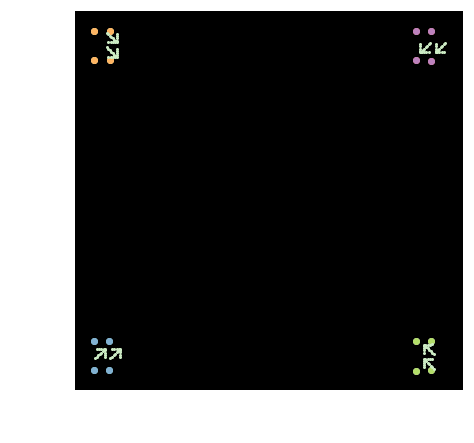

In [68]:
skyInfo = np.loadtxt(skyFilePath,skiprows=1)

skyStarId = skyInfo[:,0] ; skyRa = skyInfo[:,1] ; skyDecl = skyInfo[:,2] ; skyMag =skyInfo[:,3]


fig,ax = plt.subplots(1,1,figsize=(7,7))

#the coords are center of each sensor from 
# sourSelc.camera.getWavefrontSensor()
wavefrontSensors= sourSelc.camera.getWavefrontSensor()
for detector, wavefrontSensor in wavefrontSensors.items():
    #print(detector)#, wavefrontSensor)  
 
    corner1 = wavefrontSensor[0]
    corner2 = wavefrontSensor[1]
    corner3 = wavefrontSensor[2]
    corner4 = wavefrontSensor[3]
    ra = np.array([corner1[0], corner2[0], corner3[0], corner4[0]])
    decl = np.array([corner1[1], corner2[1], corner3[1], corner4[1]])
    m = ra>180
    ra[m] = ra[m] - 360
    #print(ra)
    #print(decl)
    ax.scatter(ra,decl)
skyRaShifted = skyRa.copy()
mask = skyRa > 180
skyRaShifted[mask] = skyRaShifted[mask]-360
ax.scatter(skyRaShifted, skyDecl,s=4)
ax.set_xlabel('RA')
ax.set_ylabel('Decl')


They're off when using `PhosimWcsSol` !   In fact, show the result of querying the star database  for `R:0,4 S:2,0,A` , plotting the stars.getRA , stars.getDecl atop the input star catalog , showing which stars get selected based on the detector boundaries : 

In [69]:
# Query the star database
starMap = dict()
neighborStarMap = dict()

# do it for a second set of stars ... 
#for detector, wavefrontSensor in wavefrontSensors.items():

detector = 'R:0,4 S:2,0,A'
wavefrontSensor = wavefrontSensors[detector]

# Get stars in this wavefront sensor for this observation field
stars = sourSelc.db.query(mappedFilterType, wavefrontSensor[0],
                          wavefrontSensor[1], wavefrontSensor[2],
                          wavefrontSensor[3])

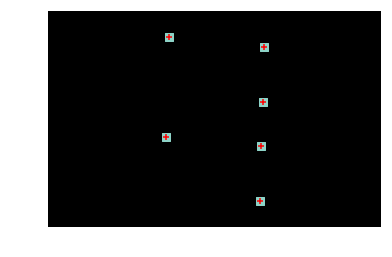

In [70]:
# the database is filled with LocalDatabaseForStarFile.insertDataByFile
# it is queried with DefaultDatabase.query that passes to 
# LocalDatabase._queryTable

# for one sensor only, as selected above 
corner1=wavefrontSensor[0]
corner2=wavefrontSensor[1]
corner3=wavefrontSensor[2]
corner4=wavefrontSensor[3]
ra = [corner1[0], corner2[0], corner3[0], corner4[0]]
decl = [corner1[1], corner2[1], corner3[1], corner4[1]]
top = max(decl)
bottom = min(decl)
left = min(ra)
right = max(ra)

# same as 
#  command = "SELECT simobjid, ra, decl, " + \
#       filterType.name.lower() + "mag" + \
#       " FROM " + tableName + \
#       " WHERE decl <= %f AND decl >= %f AND ra >= %f AND ra <= %f"
m = (skyDecl <= top) *(skyDecl >= bottom)*(skyRa >= left) *(skyRa <= right) 

# just for plotting 
# mask = skyRa > 180
# skyRaShifted = skyRa.copy()
# skyRaShifted[mask] = skyRaShifted[mask]-360
plt.scatter(skyRa[m], skyDecl[m], marker='s', s=65)
plt.scatter(stars.getRA(),stars.getDecl(),marker='+',c='r')

So the problem is that not all the stars get selected...

Show how I got the arrow stars (ra,dec) coordinates using SkySim : 

In [71]:
from lsst.ts.phosim.SkySim import SkySim
import sys
sys.path.append('/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_tools/')
import analysisTools as at

mjd = 57648  # arbitrary observation date 
raInDeg = 0 # telescope pointing in degrees 
declInDeg = 0
rotSkyPos = 0 # rotation angle in degrees 
starMag = 15 # star magnitude 

# Declare the SkySim()
skySim = SkySim()

# Set the observation information
skySim.setObservationMetaData(raInDeg, declInDeg, rotSkyPos, mjd)

sensorName = ["R44_S00_C0", "R00_S22_C0",
              "R40_S02_C0", "R04_S20_C0",
              "R44_S00_C1", "R00_S22_C1",
              "R40_S02_C1", "R04_S20_C1",
             ]

# add arrows  per half-sensor 
xPx, yPx = at.pixel_arrow(x_vertex=1500, y_vertex=3000, width=1100, 
                spacing=300, diag_spacing=200, xmin=0, xmax=2000,
                ymin=0, ymax=4072, xy_offset=1300, print_shape=False )


from astropy.table import Table
store_x = []
store_y = []
store_sen = [] 
imType = []

starId = 0 
for sensor in sensorName:
    for i in range(len(xPx)):
        skySim.addStarByChipPos(sensor, starId, xPx[i],
                                yPx[i], starMag)
        store_x.append(xPx[i])
        store_y.append(yPx[i])
        store_sen.append(sensor)
        imType.append('arrow')
        starId += 1 
        
# add outlines per half-sensor ... 
xPx, yPx = at.pixel_outline(xmin=0,  xmax=2000, ymin=0, 
                            ymax=4072,print_shape=False)
 
for sensor in sensorName:
    for i in range(len(xPx)):
        skySim.addStarByChipPos(sensor, starId, xPx[i],
                                yPx[i], starMag)
        store_x.append(xPx[i])
        store_y.append(yPx[i])
        store_sen.append(sensor)
        imType.append('outline')
        starId += 1 
        
ra,dec = skySim.getRaDecInDeg()

coords_wfs = Table(data=[ra,dec, store_x,store_y, store_sen, imType], 
             names=['ra','dec', 'xPx', 'yPx', 'sensorName', 'imType']  )


# shift just for plotting 
m = coords_wfs['ra']>180
coords_wfs['ra'][m]  = coords_wfs['ra'][m]-360



[1500 1500 1500 1500] [1900 2200 2500 2800]
[ 400  700 1000 1300] [3000 3000 3000 3000]
y=1.00x 1500.00
[ 200  400  600  800 1000 1200 1400] [1700. 1900. 2100. 2300. 2500. 2700. 2900.]
[1500. 1500. 1500. 1500.  400.  700. 1000. 1300.  200.  400.  600.  800.
 1000. 1200. 1400. 1500.] [1900. 2200. 2500. 2800. 3000. 3000. 3000. 3000. 1700. 1900. 2100. 2300.
 2500. 2700. 2900. 3000.]


Plot the SkySim detector outlines as well as arrows, on top of the `sourSelc.camera.getWavefrontSensor` detector boundaries :

R:0,0 S:2,2,A
R:0,4 S:2,0,A
R:4,0 S:0,2,A
R:4,4 S:0,0,A
R:0,0 S:2,2,B
R:0,4 S:2,0,B
R:4,0 S:0,2,B
R:4,4 S:0,0,B


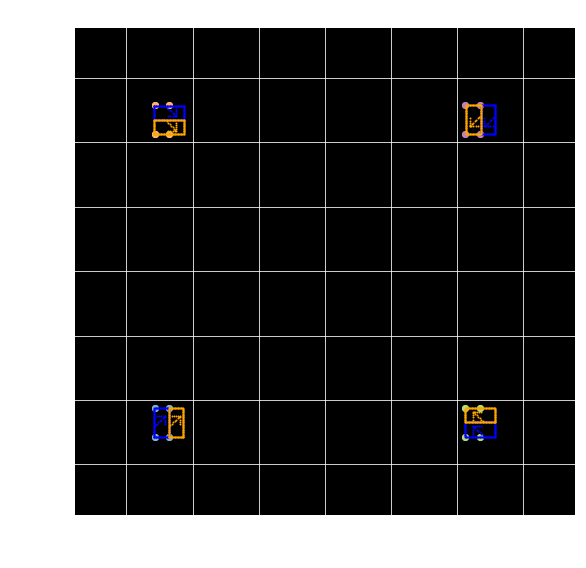

In [73]:
fig,ax = plt.subplots(1,1,figsize=(9,9))
lim = 1.9


wavefrontSensors= sourSelc.camera.getWavefrontSensor()
for detector, wavefrontSensor in wavefrontSensors.items():
    print(detector)#, wavefrontSensor)  
 
    corner1 = wavefrontSensor[0]
    corner2 = wavefrontSensor[1]
    corner3 = wavefrontSensor[2]
    corner4 = wavefrontSensor[3]
    ra = np.array([corner1[0], corner2[0], corner3[0], corner4[0]])
    decl = np.array([corner1[1], corner2[1], corner3[1], corner4[1]])
    m = ra>180
    ra[m] = ra[m] - 360
    #print(ra)
    #print(decl)
    ax.scatter(ra,decl)
    


# plot WFS (LsstCam)
for part,color in zip(['C0','C1'], ['blue','orange']):
    m = [s.endswith(part) for s in coords_wfs['sensorName']]
    ax.scatter(coords_wfs['ra'][m], coords_wfs['dec'][m],c=color,s=1)
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    

ax.set_xlabel('RA')
ax.set_ylabel('Decl')

ax.grid()
if expWcs :
    title  = "Phosim"
else:
    title = ""
plt.title('SkySim (arrows)  vs %sWcsSol (thick dots)'%title)
plt.savefig('SkySim_corner_sensors_%sWcsSol.png'%title,bbox_inches='tight')


In [72]:
expWcs


True